# 1. Import and Install Dependencies

In [2]:
# tracking stuff
!pip install  opencv-python mediapipe sklearn matplotlib 
#tensorflow-gpu==2.4.1
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# sound stuff
!pip install pyaudio
!pip install pysinewave
import time
import pyaudio
from pysinewave import SineWave
import pyaudio as p
import math
import threading

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

this is for the frequency stuff

In [15]:
def pitch_to_freq(pitch):
    return 440 * 2 ^ ((pitch-9)/12)

def freq_to_pitch(freq):
    return 12 * math.log2(freq/440) + 9

# CHORDS = {
#     0   : [-10, -6, -4],
#     0.1 : [-7, -4, -2],
#     0.2 : [-5, -2, 1],
#     0.3 : [-3, 1, 3],
#     0.4 : [-1, 3, 5],
#     0.5 : [0, 4, 7],
#     0.6 : [2, 5, 9],
#     0.7 : [3, 7, 10],
#     0.8 : [5, 9, 12],
#     0.9 : [7, 11, 14],
#     1   : [9, 13, 16]
# }

CHORDS = {
    0   : [-6, -2, 1],
    0.1 : [-5, -1, 2],
    0.2 : [-4, 0, 3],
    0.3 : [-2, 2, 5],
    0.4 : [-1, 3, 6],
    0.5 : [0, 4, 7],
    0.6 : [0.5, 5, 8],
    0.7 : [2, 6, 9],
    0.8 : [4, 8, 11],
    0.9 : [5, 9, 12],
    1   : [6, 10, 13]
}



class Waves:
    def __init__(self):
        self.wave1 = SineWave(pitch=0, pitch_per_second=100, decibels_per_second=100)
        self.wave2 = SineWave(pitch=4, pitch_per_second=100, decibels_per_second=100)
        self.wave3 = SineWave(pitch=7, pitch_per_second=100, decibels_per_second=100)
        self.waves = [self.wave1, self.wave2, self.wave3]

    def get_chords(self, x_pos):
        chord = [0, 4, 7]
        offset = 2
        difference = x_pos - 0.5

        new_chord = []
        for c in chord:
            new_chord.append(c + (difference*10) + offset)

        return new_chord

    def update_chord(self, x_pos):
        pitches = CHORDS[x_pos]
        for i in range(3):
            self.waves[i].set_pitch(pitches[i])

        self.run()

    def set_volume(self, volume):
        for wave in self.waves:
            wave.set_volume(volume)

    def run(self):
        for wave in self.waves:
            wave.play()
        # time.sleep(1.5) # Comment out when done

    def stop(self):
        for wave in self.waves:
            wave.stop()

this runs the video feed

In [7]:
cap = cv2.VideoCapture(0)
# get height and width of screen
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

sine_wave = Waves()
sine_wave.run()

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    y_pos = 0
    x_pos = 0

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)

        # from results find left hand position and caalculate what pitch to play
        
        if results.right_hand_landmarks != None:
            left_pos = results.right_hand_landmarks.landmark[0]
            y_pos = left_pos.y
        if results.right_hand_landmarks != None:
            right_pos = results.right_hand_landmarks.landmark[0]
            x_pos = right_pos.x
            
            # range 0 to 50
            y_pos = 1 - y_pos
            volume = y_pos * 50
            sine_wave.set_volume(volume)

            # range -10 to 10
            x_pos = 1 - x_pos
            x_pos = round(x_pos, 1)
            sine_wave.update_chord(x_pos)
            
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    sine_wave.stop()
    cv2.destroyAllWindows()

In [8]:
cap.release()

In [9]:
draw_landmarks(frame, results)

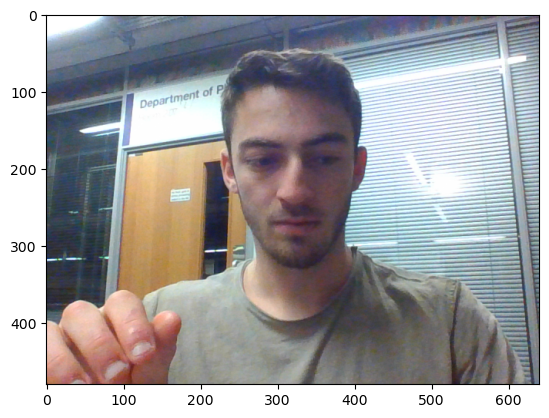

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [11]:
results.right_hand_landmarks.landmark

AttributeError: 'NoneType' object has no attribute 'landmark'

In [3]:
def extract_keypoints(results):
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    # pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    # return np.concatenate([pose, face, lh, rh])
    # return np.concatenate([lh, rh])
    return rh

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
result_test.shape

(63,)

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

array([ 0.46479714,  0.47042787, -0.03023029, ...,  0.53018653,
        0.32886922,  0.0141443 ])

# 4. Setup Folders for Collection

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
# actions = np.array(['hello', 'thanks', 'iloveyou'])
actions = np.array(['nothing', 'no_gesgure', 'index_finger', 'fist'])

# Thirty videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 25

# Folder start
# start_folder = 30

In [5]:
for action in actions: 
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(0,no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [236]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        cv2.waitKey(5000)
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    # cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [165]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
label_map = {label:num for num, label in enumerate(actions)}

In [21]:
label_map

{'nothing': 0, 'no_gesgure': 1, 'index_finger': 2, 'fist': 3}

In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
np.array(sequences).shape

(160, 25, 63)

In [265]:
np.array(labels).shape

(160,)

In [10]:
X = np.array(sequences)

In [267]:
X.shape

(160, 25, 63)

In [11]:
y = to_categorical(labels).astype(int)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [27]:
y_test.shape

(8, 4)

In [26]:
X = X[:,:30,:]
print(X.shape)

(100, 20, 63)


# 7. Build and Train LSTM Neural Network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [14]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(25,63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [275]:
model.fit(X_train, y_train, epochs=300, callbacks=[tb_callback])

Epoch 1/300
5/5 [==============================] - 3s 29ms/step - loss: 1.3745 - categorical_accuracy: 0.3355
Epoch 2/300
5/5 [==============================] - 0s 27ms/step - loss: 1.3087 - categorical_accuracy: 0.2697
Epoch 3/300
5/5 [==============================] - 0s 27ms/step - loss: 1.2911 - categorical_accuracy: 0.4211
Epoch 4/300
5/5 [==============================] - 0s 26ms/step - loss: 1.2478 - categorical_accuracy: 0.5855
Epoch 5/300
5/5 [==============================] - 0s 27ms/step - loss: 1.1957 - categorical_accuracy: 0.5066
Epoch 6/300
5/5 [==============================] - 0s 28ms/step - loss: 1.1408 - categorical_accuracy: 0.5197
Epoch 7/300
5/5 [==============================] - 0s 26ms/step - loss: 1.1176 - categorical_accuracy: 0.6118
Epoch 8/300
5/5 [==============================] - 0s 27ms/step - loss: 1.1276 - categorical_accuracy: 0.5197
Epoch 9/300
5/5 [==============================] - 0s 29ms/step - loss: 1.0475 - categorical_accuracy: 0.6382
Epoch 10/3

KeyboardInterrupt: 

In [276]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 25, 64)            32768     
                                                                 
 lstm_49 (LSTM)              (None, 25, 128)           98816     
                                                                 
 lstm_50 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 4)                 132       
                                                                 
Total params: 187,364
Trainable params: 187,364
Non-t

# 8. Make Predictions

In [277]:
res = model.predict(X_test)

1/1 [==============================] - 0s 259ms/step


In [278]:
print(y_test)

[[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]


In [282]:
for i in range(len(y_test)):
    print(actions[np.argmax(res[i])])
print(label_map)

index_finger
nothing
no_gesgure
no_gesgure
no_gesgure
fist
nothing
no_gesgure
{'nothing': 0, 'no_gesgure': 1, 'index_finger': 2, 'fist': 3}


In [229]:
actions[np.argmax(y_test[])]

SyntaxError: invalid syntax (3999495826.py, line 1)

# 9. Save Weights

In [283]:
model.save('test_model.h5')

In [ ]:
del model

In [17]:
model.load_weights('test_model.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [18]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 516ms/step


In [285]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [286]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[6, 0],
        [0, 2]],

       [[4, 0],
        [0, 4]],

       [[7, 0],
        [0, 1]],

       [[7, 0],
        [0, 1]]], dtype=int64)

In [86]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [19]:
from scipy import stats

In [287]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [288]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

sounds

In [10]:
!pip install simpleaudio

  Using cached simpleaudio-1.0.4.tar.gz (2.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for simpleaudio
Failed to build simpleaudio
  Running setup.py install for simpleaudio: started
  Running setup.py install for simpleaudio: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\simpleaudio
      copying simpleaudio\__init__.py -> build\lib.win-amd64-cpython-39\simpleaudio
      copying simpleaudio\shiny.py -> build\lib.win-amd64-cpython-39\simpleaudio
      copying simpleaudio\functionchecks.py -> build\lib.win-amd64-cpython-39\simpleaudio
      creating build\lib.win-amd64-cpython-39\simpleaudio\test_audio
      copying simpleaudio\test_audio\c.wav -> build\lib.win-amd64-cpython-39\simpleaudio\test_audio
      copying simpleaudio\test_audio\e.wav -> build\lib.win-amd64-cpython-39\simpleaudio\test_audio
      copying simpleaudio\test_audio\g.wav -> build\lib.win-amd64-cpython-39\simpleaudio\test_audio
      copying simpleaudio\test_audio\le

pygame

In [ ]:
# Initialize Pygame
pygame.mixer.init()

# Set the number of mixer channels
pygame.mixer.set_num_channels(3)

# Load the sound files
sound1 = pygame.mixer.Sound('high-hat.wav')
sound2 = pygame.mixer.Sound('bass.wav')
sound3 = pygame.mixer.Sound('synth-chord.wav')

# Define a function to play sounds based on input
def play_sound(input):
    if input == 1:
        channel = pygame.mixer.Channel(0)
        channel.play(sound1)
    elif input == 2:
        channel = pygame.mixer.Channel(1)
        channel.play(sound2)
    elif input == 3:
        channel = pygame.mixer.Channel(2)
        channel.play(sound3)

In [11]:
import threading
import wave
import pyaudio
import simpleaudio as sa

class Loops:
    def __init__(self):
        self.FILENAMES = {
            'bass': 'bass.wav',
            'back-beat': 'back-beat.wav',
            'echo-synth': 'echo-synth.wav',
            'high-hat': 'high-hat.wav',
            'paddington-bass': 'paddington-bass.wav',
            'synth-chord': 'synth-chord.wav'
        }

        self.wf1 = wave.open(self.FILENAMES['bass'], 'rb')
        self.p1 = pyaudio.PyAudio()
        self.stream1 = self.p1.open(format=self.p1.get_format_from_width(self.wf1.getsampwidth()),
                        channels=self.wf1.getnchannels(),
                        rate=self.wf1.getframerate(),
                        output=True)

        self.wf2 = wave.open(self.FILENAMES['back-beat'], 'rb')
        self.p2 = pyaudio.PyAudio()
        self.stream2 = self.p2.open(format=self.p2.get_format_from_width(self.wf2.getsampwidth()),
                                    channels=self.wf2.getnchannels(),
                                    rate=self.wf2.getframerate(),
                                    output=True)

        self.wf3 = wave.open(self.FILENAMES['echo-synth'], 'rb')
        self.p3 = pyaudio.PyAudio()
        self.stream3 = self.p1.open(format=self.p3.get_format_from_width(self.wf3.getsampwidth()),
                                    channels=self.wf3.getnchannels(),
                                    rate=self.wf3.getframerate(),
                                    output=True)

        self.wf4 = wave.open(self.FILENAMES['high-hat'], 'rb')
        self.p4 = pyaudio.PyAudio()
        self.stream4 = self.p4.open(format=self.p4.get_format_from_width(self.wf4.getsampwidth()),
                                    channels=self.wf4.getnchannels(),
                                    rate=self.wf4.getframerate(),
                                    output=True)

        self.wf5 = wave.open(self.FILENAMES['paddington-bass'], 'rb')
        self.p5 = pyaudio.PyAudio()
        self.stream5 = self.p5.open(format=self.p5.get_format_from_width(self.wf5.getsampwidth()),
                                    channels=self.wf5.getnchannels(),
                                    rate=self.wf5.getframerate(),
                                    output=True)

        self.wf6 = wave.open(self.FILENAMES['synth-chord'], 'rb')
        self.p6 = pyaudio.PyAudio()
        self.stream6 = self.p6.open(format=self.p6.get_format_from_width(self.wf6.getsampwidth()),
                                    channels=self.wf6.getnchannels(),
                                    rate=self.wf6.getframerate(),
                                    output=True)

    def play_bass(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf1.readframes(chunk_size)

        while len(data) > 0:
            self.stream1.write(data)
            data = self.wf1.readframes(chunk_size)
        # Clean up
        self.stream1.stop_stream()
        self.stream1.close()
        self.p1.terminate()

    def play_back_beat(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf2.readframes(chunk_size)

        while len(data) > 0:
            self.stream2.write(data)
            data = self.wf2.readframes(chunk_size)
        # Clean up
        self.stream2.stop_stream()
        self.stream2.close()
        self.p2.terminate()

    def play_echo_synth(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf3.readframes(chunk_size)

        while len(data) > 0:
            self.stream3.write(data)
            data = self.wf3.readframes(chunk_size)
        # Clean up
        self.stream3.stop_stream()
        self.stream3.close()
        self.p3.terminate()

    def play_high_hat(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf4.readframes(chunk_size)

        while len(data) > 0:
            self.stream4.write(data)
            data = self.wf4.readframes(chunk_size)
        # Clean up
        self.stream4.stop_stream()
        self.stream4.close()
        self.p4.terminate()

    def play_paddington_bass(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf5.readframes(chunk_size)

        while len(data) > 0:
            self.stream5.write(data)
            data = self.wf5.readframes(chunk_size)
        # Clean up
        self.stream5.stop_stream()
        self.stream5.close()
        self.p5.terminate()

    def play_synth_chord(self):
        # Read and play the audio in chunks
        chunk_size = 1024
        data = self.wf6.readframes(chunk_size)

        while len(data) > 0:
            self.stream6.write(data)
            data = self.wf6.readframes(chunk_size)
        # Clean up
        self.stream6.stop_stream()
        self.stream6.close()
        self.p6.terminate()


class PlayWav:
    def __init__(self):
        self.FILENAMES = {
            'bass': 'bass.wav',
            'back-beat': 'back-beat.wav',
            'echo-synth': 'echo-synth.wav',
            'high-hat': 'high-hat.wav',
            'paddington-bass': 'paddington-bass.wav',
            'synth-chord': 'synth-chord.wav'
        }
        self.threads = []

    def play_wav(self, filename):
        wave_obj = sa.WaveObject.from_wave_file(self.FILENAMES[filename])
        play_obj = wave_obj.play()
        play_obj.wait_done()
        


if __name__ == '__main__':
    pw = PlayWav()
    # pw.play_wav('bass')
    # l = Loops()

    thread1 = threading.Thread(target=pw.play_wav, args=('bass',))
    thread2 = threading.Thread(target=pw.play_wav, args=('synth-chord',))
    thread1.start()
    thread2.start()

    thread1.join()
    thread2.join()


ModuleNotFoundError: No module named 'simpleaudio'

In [36]:
def make_visual_pred(model):
    # 1. New detection variables
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    cap = cv2.VideoCapture(0)

    # stuff for loops
    l = Loops()
    thread1 = threading.Thread(target=l.play_bass)
    count = 0
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()

            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            print(results)
            
            # Draw landmarks
            draw_styled_landmarks(image, results)
            
            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-sequence_length:]
            
            if len(sequence) == sequence_length:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                
            # #3. Viz logic
            #     if np.unique(predictions[-10:])[0]==np.argmax(res): 
            #         if res[np.argmax(res)] > threshold: 
                        
            #             if len(sentence) > 0: 
            #                 if actions[np.argmax(res)] != sentence[-1]:
            #                     sentence.append(actions[np.argmax(res)])
            #             else:
            #                 sentence.append(actions[np.argmax(res)])

            #     if len(sentence) > 5: 
            #         sentence = sentence[-5:]

            #     # Viz probabilities
            #     image = prob_viz(res, actions, image, colors)
            
            
                guess = np.argmax(res)
                print(guess)
                sentence = actions[guess]
                if count == 100:
                    sentence = actions[guess]
                    sentence = 'fist'
                    if sentence == 'fist':
                        thread1.start()
                        thread1.join()
                    if sentence == 'index_finger':
                        thread2 = threading.Thread(target=l.play_back_beat)
                        thread2.start()
                        thread2.join()
            
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # # Show to screen
            cv2.imshow('OpenCV Feed', image)
            count += 1
            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

if __name__  == '__main__':
    main_thread = threading.Thread(target=make_visual_pred, args=(model, ))
    main_thread.start()
    main_thread.join()
    # thread1 = threading.Thread(target=l.play_bass)

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [4]:
cap.release()